In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
project_path = '/content/drive/My Drive/multidisease detection'
os.chdir(project_path)


In [ ]:
!ls


data  main.py  src


In [ ]:
!pip install -r requirements.txt


In [ ]:
%cd /content/drive/MyDrive/multidisease detection/


/content


In [ ]:
!pwd


/content/drive/MyDrive/multidisease detection


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!unzip "/content/drive/MyDrive/multidisease detection/data/images_resized.zip" -d "/content/drive/MyDrive/multidisease detection/data/images_resized"


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00028897_014.png  
  inflating: /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00028897_015.png  
  inflating: /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00028897_016.png  
  inflating: /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00028897_017.png  
  inflating: /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00028897_018.png  
  inflating: /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00028897_019.png  
  inflating: /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00028897_020.png  
  inflating: /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00028898_000.png  
  inflating: /content/drive/MyDrive/multidise

In [ ]:
!find "/content/drive/MyDrive/multidisease detection/data/images_resized" -type f -iname "*.png" | wc -l


112120


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/multidisease detection")


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

import warnings
import logging

#supressing logs and warnings

try:
    cv2.utils.logging.setLogLevel(cv2.utils.logging.LOG_LEVEL_ERROR)
except:
    import os
    os.environ['OPENCV_LOG_LEVEL'] = 'SILENT'

warnings.filterwarnings('ignore')

logging.getLogger('tensorflow').setLevel(logging.ERROR)


class ChestXrayGenerator(Sequence):
    def __init__(self, df, image_dir, batch_size=32, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        X = []
        y = []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.image_dir, row['Image Index'])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:

                with open("corrupt_images.txt", "a") as f:
                    f.write(img_path + "\n")
                continue


            img = preprocess_image(img)
            X.append(img)
            y.append(row['Target'].split('|'))

        if len(X) == 0:
            return np.empty((0, 224, 224, 1)), np.empty((0, 14))

        X = np.array(X)
        y = multilabel_binarize(y)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

def preprocess_image(img):
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    #resizing to 224x224
    img = cv2.resize(img, (224, 224))

    #normalizing to [0, 1]
    img = img / 255.0

    #adding channel dimension for grayscale: (224, 224) to (224, 224, 1)
    img = np.expand_dims(img, axis=-1)
    return img

def multilabel_binarize(y_batch):
    all_labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
                  'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
                  'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
    binarized = np.zeros((len(y_batch), len(all_labels)))
    for i, labels in enumerate(y_batch):
        for label in labels:
            if label in all_labels:
                binarized[i, all_labels.index(label)] = 1
    return binarized

def clean_metadata(df):
    #dropping missing labels
    df = df[df['Finding Labels'].notna()]

    df = df.drop_duplicates(subset='Image Index')

    df['Finding Labels'] = df['Finding Labels'].replace('No Finding', '')

    return df

def get_data_generators(csv_path="data/Data_Entry_2017.csv", image_dir="data/images_resized", batch_size=32):
    df = pd.read_csv(csv_path)
    df = clean_metadata(df)

    df['Target'] = df['Finding Labels']
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

    train_gen = ChestXrayGenerator(train_df, image_dir=image_dir, batch_size=batch_size)
    val_gen = ChestXrayGenerator(val_df, image_dir=image_dir, batch_size=batch_size)
    test_gen = ChestXrayGenerator(test_df, image_dir=image_dir, batch_size=batch_size, shuffle=False)

    return train_gen, val_gen, test_gen


In [ ]:
train_gen, val_gen, test_gen = get_data_generators(
    csv_path="/content/drive/MyDrive/multidisease detection/data/Data_Entry_2017.csv",
    image_dir="/content/drive/MyDrive/multidisease detection/data/images_resized",
    batch_size=32
)


In [ ]:
X, y = train_gen[0]
print("X shape:", X.shape)
print("y sample:", y[:5])
print("Sum of y (labels):", np.sum(y))


X shape: (0, 224, 224, 1)
y sample: []
Sum of y (labels): 0.0


In [ ]:
import os
import cv2

image_dir = "/content/drive/MyDrive/multidisease detection/data/images_resized"
csv_path = "/content/drive/MyDrive/multidisease detection/data/Data_Entry_2017.csv"

import pandas as pd
df = pd.read_csv(csv_path)
df = df[df['Finding Labels'].notna()]
df = df.drop_duplicates(subset='Image Index')

unreadable = []

for img_name in df['Image Index'].values[:100]:
    img_path = os.path.join(image_dir, img_name)
    if not os.path.exists(img_path):
        unreadable.append(img_name)
    else:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            unreadable.append(img_name)

print("Unreadable images (first 100 checked):", len(unreadable))
print(unreadable[:10])


Unreadable images (first 100 checked): 100
['00000001_000.png', '00000001_001.png', '00000001_002.png', '00000002_000.png', '00000003_001.png', '00000003_002.png', '00000003_003.png', '00000003_004.png', '00000003_005.png', '00000003_006.png']


In [ ]:
!ls -lh "/content/drive/MyDrive/multidisease detection/data/images_resized" | head -n 20


total 4.0K
drwx------ 2 root root 4.0K Aug  3 17:33 images_resized


In [ ]:
!ls -lh "/content/drive/MyDrive/multidisease detection/data/images_resized" | head


total 4.0K
drwx------ 2 root root 4.0K Aug  3 17:33 images_resized


In [ ]:
X, y = train_gen[0]
print(X.shape, y.shape)


(0, 224, 224, 1) (0, 14)


In [ ]:
import cv2
import os
from tqdm import tqdm

original_dir = "/content/drive/MyDrive/multidisease detection/data/images_resized"
resized_dir = "/content/drive/MyDrive/multidisease detection/data/images"

os.makedirs(resized_dir, exist_ok=True)

image_list = os.listdir(original_dir)

for filename in tqdm(image_list):
    src_path = os.path.join(original_dir, filename)
    dst_path = os.path.join(resized_dir, filename)

    img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    img = cv2.resize(img, (224, 224))
    cv2.imwrite(dst_path, img)


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


In [ ]:
import os

image_dir = "/content/drive/MyDrive/multidisease detection/data/images_resized"
files = os.listdir(image_dir)
print("Total images found:", len(files))
print("First 10 files:", files[:10])


Total images found: 1
First 10 files: ['images_resized']


In [ ]:
X, y = train_gen[0]
print("X shape:", X.shape)
print("y sample:", y[:5])
print("Sum of y (labels):", np.sum(y))


X shape: (0, 224, 224, 1)
y sample: []
Sum of y (labels): 0.0


In [ ]:
import os

image_dir = "/content/drive/MyDrive/multidisease detection/data/images_resized/images_resized"  # <-- your updated path
files = os.listdir(image_dir)

#counting png
images = [f for f in files if f.endswith('.png')]
print("Total PNG images found:", len(images))
print("First 5:", images[:5])


Total PNG images found: 112120
First 5: ['00000001_000.png', '00000001_001.png', '00000001_002.png', '00000002_000.png', '00000003_000.png']


In [ ]:
import cv2
import numpy as np

def test_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image not readable:", img_path)
        return
    print("Image shape before preprocessing:", img.shape)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)

    print("Processed image shape:", img.shape)

img_test_path = os.path.join(image_dir, images[0])
test_preprocess(img_test_path)


Image shape before preprocessing: (224, 224)
Processed image shape: (224, 224, 1)


In [ ]:
!find "/content/drive/MyDrive/multidisease detection/data/images_resized/images_resized" -name "*.png" -exec ls -lh {} \; | head -10


-rw------- 1 root root 26K Aug  3 16:14 /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00000001_000.png
-rw------- 1 root root 26K Aug  3 16:14 /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00000001_001.png
-rw------- 1 root root 23K Aug  3 16:14 /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00000001_002.png
-rw------- 1 root root 25K Aug  3 16:14 /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00000002_000.png
-rw------- 1 root root 26K Aug  3 16:14 /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00000003_000.png
-rw------- 1 root root 25K Aug  3 16:14 /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00000003_001.png
-rw------- 1 root root 22K Aug  3 16:14 /content/drive/MyDrive/multidisease detection/data/images_resized/images_resized/00000003_002.png
-rw------- 1 root root 25K Aug  3 

In [ ]:
import os
import pandas as pd
csv_path = "/content/drive/MyDrive/multidisease detection/data/Data_Entry_2017.csv"
image_dir = "/content/drive/MyDrive/multidisease detection/data/images_resized/images_resized"


df = pd.read_csv(csv_path)
csv_filenames = set(df['Image Index'].unique())

actual_files = set(os.listdir(image_dir))
missing = csv_filenames - actual_files
print(f"Total image names in CSV: {len(csv_filenames)}")
print(f"Total actual image files: {len(actual_files)}")
print(f"Missing images (present in CSV but not in folder): {len(missing)}")
print("First few missing files:", list(missing)[:5])


Total image names in CSV: 112120
Total actual image files: 112120
Missing images (present in CSV but not in folder): 0
First few missing files: []


In [ ]:
import os
import shutil

src_dir = "/content/drive/MyDrive/multidisease detection/data/images_resized/images_resized"
dest_dir = "/content/drive/MyDrive/multidisease detection/data/images_resized"

moved = 0
for filename in os.listdir(src_dir):
    src_path = os.path.join(src_dir, filename)
    dest_path = os.path.join(dest_dir, filename)

    if os.path.isfile(src_path):
        shutil.move(src_path, dest_path)
        moved += 1

print(f"Moved {moved} files.")


Moved 112120 files.


In [ ]:
!rm -r /content/drive/MyDrive/multidisease\ detection/data/images_resized/images_resized


In [ ]:
import os

image_dir = "/content/drive/MyDrive/multidisease detection/data/images_resized"
files = os.listdir(image_dir)
print("Total files:", len(files))
print("First 10 files:", files[:10])


Total files: 112120
First 10 files: ['00000001_000.png', '00000001_001.png', '00000001_002.png', '00000002_000.png', '00000003_000.png', '00000003_001.png', '00000003_002.png', '00000003_003.png', '00000003_004.png', '00000003_005.png']


In [ ]:
train_gen, val_gen, test_gen = get_data_generators(
    csv_path="/content/drive/MyDrive/multidisease detection/data/Data_Entry_2017.csv",
    image_dir="/content/drive/MyDrive/multidisease detection/data/images_resized",
    batch_size=32
)

X, y = train_gen[0]
print("X shape:", X.shape)
print("y sample:", y[:5])
print("Sum of y (labels):", np.sum(y))


X shape: (32, 224, 224, 1)
y sample: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Sum of y (labels): 20.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/multidisease detection


/content


In [ ]:
!python3 main.py


Epoch 1/5
 257/2803 ━━━━━━━━━━━━━━━━━━━━ 51:35 1s/step - accuracy: 0.1514 - loss: 0.2168

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)


Num GPUs Available: 1


In [ ]:
!python3 main.py

Epoch 1/5
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 1138s 655ms/step - accuracy: 0.1867 - loss: 0.1855 - val_accuracy: 0.1287 - val_loss: 0.1998 - learning_rate: 0.0010
Epoch 2/5
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 851s 607ms/step - accuracy: 0.2175 - loss: 0.1654 - val_accuracy: 0.1117 - val_loss: 0.1913 - learning_rate: 0.0010
Epoch 3/5
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 855s 602ms/step - accuracy: 0.2425 - loss: 0.1618 - val_accuracy: 0.0468 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 4/5
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 884s 631ms/step - accuracy: 0.2615 - loss: 0.1578 - val_accuracy: 0.1316 - val_loss: 0.1850 - learning_rate: 0.0010
Epoch 5/5
1401/1401 ━━━━━━━━━━━━━━━━━━━━ 843s 602ms/step - accuracy: 0.2621 - loss: 0.1562 - val_accuracy: 0.1844 - val_loss: 0.1780 - learning_rate: 0.0010
Final model saved at: /content/drive/MyDrive/multidisease detection/checkpoints/final_model.h5
Figure(1200x400)
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/multidisease detection/checkpoints/final_model.h5')


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/multidisease detection/src')

from src.dataloader import get_data_generators
from src.dataloader import ChestXrayGenerator
from src.evaluate import evaluate_model


In [ ]:
_, _, test_gen = get_data_generators(
    csv_path="/content/drive/MyDrive/multidisease detection/data/Data_Entry_2017.csv",
    image_dir="/content/drive/MyDrive/multidisease detection/data/images_resized",
    batch_size=128
)


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
tf.debugging.set_log_device_placement(True)


In [ ]:
!cp -r /content/drive/MyDrive/p /content/images


cp: cannot stat '/content/drive/MyDrive/path_to_images': No such file or directory


In [ ]:
from tensorflow.keras.models import load_model
from dataloader import get_data_generators
from evaluate import evaluate_model

model_path = "/content/drive/MyDrive/multidisease detection/checkpoints/final_model.h5"
csv_path = "/content/drive/MyDrive/multidisease detection/data/Data_Entry_2017.csv"
image_dir = "/content/drive/MyDrive/multidisease detection/data/images_resized"

model = load_model(model_path)
_, _, test_gen = get_data_generators(csv_path, image_dir, batch_size=64)

evaluate_model(model, test_gen)


175/175 ━━━━━━━━━━━━━━━━━━━━ 8577s 49s/step
y_true shape: (11200, 14)
y_pred shape: (11200, 14)
Atelectasis: AUC = 0.7458
Cardiomegaly: AUC = 0.8602
Effusion: AUC = 0.8235
Infiltration: AUC = 0.6425
Mass: AUC = 0.7693
Nodule: AUC = 0.6307
Pneumonia: AUC = 0.6682
Pneumothorax: AUC = 0.7159
Consolidation: AUC = 0.7557
Edema: AUC = 0.8372
Emphysema: AUC = 0.6942
Fibrosis: AUC = 0.6467
Pleural_Thickening: AUC = 0.7040
Hernia: AUC = 0.7745

Classification Report (Threshold = 0.5):
                    precision    recall  f1-score   support

       Atelectasis       0.43      0.01      0.02      1108
      Cardiomegaly       0.44      0.02      0.03       254
          Effusion       0.42      0.41      0.41      1325
      Infiltration       0.50      0.00      0.00      1976
              Mass       0.59      0.03      0.05       557
            Nodule       0.00      0.00      0.00       610
         Pneumonia       0.00      0.00      0.00       170
      Pneumothorax       0.23      0.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
PROJECT_DIR = '/content/drive/MyDrive/multidisease detection'
CSV_PATH = os.path.join(PROJECT_DIR, 'data', 'Data_Entry_2017.csv')
IMAGE_DIR = os.path.join(PROJECT_DIR, 'data', 'images_resized')
CHECKPOINT_PATH = os.path.join(PROJECT_DIR, 'checkpoints', 'final_model.h5')
OUTPUT_DIR = os.path.join(PROJECT_DIR, 'evaluation_results')
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("CSV:", CSV_PATH)
print("Images:", IMAGE_DIR)
print("Model:", CHECKPOINT_PATH)
print("Output dir:", OUTPUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV: /content/drive/MyDrive/multidisease detection/data/Data_Entry_2017.csv
Images: /content/drive/MyDrive/multidisease detection/data/images_resized
Model: /content/drive/MyDrive/multidisease detection/checkpoints/final_model.h5
Output dir: /content/drive/MyDrive/multidisease detection/evaluation_results


In [ ]:
import os, sys, json
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             classification_report, roc_curve, auc, precision_recall_curve,
                             confusion_matrix)
import matplotlib.pyplot as plt

CLASS_NAMES = ['Atelectasis','Cardiomegaly','Effusion','Infiltration',
               'Mass','Nodule','Pneumonia','Pneumothorax','Consolidation',
               'Edema','Emphysema','Fibrosis','Pleural_Thickening','Hernia']

print("Classes:", len(CLASS_NAMES))


Classes: 14


In [ ]:
def preprocess_image_path(path, target_size=(224,224)):
    """Load grayscale image, apply CLAHE, resize, normalize, return shape (224,224,1) float32.
       Returns None if image can't be read."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    try:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
    except Exception:
        pass
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    return img


In [ ]:
model = load_model(CHECKPOINT_PATH)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      3,136 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,045,584 (26.88 MB)

 Trainable params: 6,961,934 (26.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
df = pd.read_csv(CSV_PATH)
df = df[df['Finding Labels'].notna()].drop_duplicates(subset='Image Index')
df['Target'] = df['Finding Labels'].fillna('')

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

print("Test examples:", len(test_df))
true_label_map = test_df.set_index('Image Index')['Target'].to_dict()


Test examples: 11212


In [ ]:
def labels_to_multihot(label_str):
    if not isinstance(label_str, str) or label_str.strip() == '':
        return np.zeros(len(CLASS_NAMES), dtype=np.uint8)
    labels = [x.strip() for x in label_str.split('|') if x.strip()]
    arr = np.zeros(len(CLASS_NAMES), dtype=np.uint8)
    for l in labels:
        if l in CLASS_NAMES:
            arr[CLASS_NAMES.index(l)] = 1
    return arr


In [ ]:
batch_size = 64

filenames = []
y_true_list = []
y_pred_list = []
corrupt_files = []

test_index_list = test_df.index.tolist()

for start in range(0, len(test_index_list), batch_size):
    batch_idxs = test_index_list[start:start+batch_size]
    X_batch = []
    idxs_used = []
    for idx in batch_idxs:
        row = test_df.loc[idx]
        img_name = row['Image Index']
        img_path = os.path.join(IMAGE_DIR, img_name)
        img = preprocess_image_path(img_path)
        if img is None:
            corrupt_files.append(img_name)
            continue
        X_batch.append(img)
        idxs_used.append(idx)
    if len(X_batch) == 0:
        continue
    X_batch = np.stack(X_batch, axis=0)
    preds = model.predict(X_batch, verbose=0)
    true_multihot = np.array([labels_to_multihot(test_df.loc[i, 'Target']) for i in idxs_used])
    filenames.extend([test_df.loc[i, 'Image Index'] for i in idxs_used])
    y_true_list.append(true_multihot)
    y_pred_list.append(preds)

if len(y_true_list) == 0:
    raise RuntimeError("No valid test images were processed. Check IMAGE_DIR and image file integrity.")
y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)
print("Valid images processed:", y_true.shape[0])
print("Corrupt/skipped images:", len(corrupt_files))

with open(os.path.join(OUTPUT_DIR, 'corrupt_images.txt'), 'w') as f:
    for fn in corrupt_files:
        f.write(fn + '\n')


Valid images processed: 11212
Corrupt/skipped images: 0


In [ ]:
batch_size = 64

filenames = []
y_true_list = []
y_pred_list = []
corrupt_files = []

test_index_list = test_df.index.tolist()

for start in range(0, len(test_index_list), batch_size):
    batch_idxs = test_index_list[start:start+batch_size]
    X_batch = []
    idxs_used = []
    for idx in batch_idxs:
        row = test_df.loc[idx]
        img_name = row['Image Index']
        img_path = os.path.join(IMAGE_DIR, img_name)
        img = preprocess_image_path(img_path)
        if img is None:
            corrupt_files.append(img_name)
            continue
        X_batch.append(img)
        idxs_used.append(idx)
    if len(X_batch) == 0:
        continue
    X_batch = np.stack(X_batch, axis=0)
    preds = model.predict(X_batch, verbose=0)
    true_multihot = np.array([labels_to_multihot(test_df.loc[i, 'Target']) for i in idxs_used])
    filenames.extend([test_df.loc[i, 'Image Index'] for i in idxs_used])
    y_true_list.append(true_multihot)
    y_pred_list.append(preds)

if len(y_true_list) == 0:
    raise RuntimeError("No valid test images were processed. Check IMAGE_DIR and image file integrity.")
y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)
print("Valid images processed:", y_true.shape[0])
print("Corrupt/skipped images:", len(corrupt_files))

with open(os.path.join(OUTPUT_DIR, 'corrupt_images.txt'), 'w') as f:
    for fn in corrupt_files:
        f.write(fn + '\n')


Valid images processed: 11212
Corrupt/skipped images: 0


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

metrics = {}
per_class_auc = {}
valid_auc_classes = []

for i, cname in enumerate(CLASS_NAMES):
    y_true_col = y_true[:, i]
    y_pred_col = y_pred[:, i]

    if np.unique(y_true_col).size < 2:
        per_class_auc[cname] = None
    else:
        per_class_auc[cname] = float(roc_auc_score(y_true_col, y_pred_col))
        valid_auc_classes.append(cname)

metrics['per_class_auc'] = per_class_auc


try:
    metrics['auc_micro'] = float(roc_auc_score(y_true, y_pred, average='micro'))
except Exception as e:
    metrics['auc_micro'] = str(e)
try:
    metrics['auc_macro'] = float(roc_auc_score(y_true, y_pred, average='macro'))
except Exception as e:
    metrics['auc_macro'] = str(e)

threshold = 0.5
y_pred_bin = (y_pred >= threshold).astype(int)
prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred_bin, average=None, zero_division=0)

metrics['per_class_precision'] = dict(zip(CLASS_NAMES, prec.tolist()))
metrics['per_class_recall'] = dict(zip(CLASS_NAMES, rec.tolist()))
metrics['per_class_f1'] = dict(zip(CLASS_NAMES, f1.tolist()))
metrics['support'] = dict(zip(CLASS_NAMES, sup.tolist()))

p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred_bin, average='micro', zero_division=0)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred_bin, average='macro', zero_division=0)
metrics['overall'] = {
    'precision_micro': float(p_micro), 'recall_micro': float(r_micro), 'f1_micro': float(f1_micro),
    'precision_macro': float(p_macro), 'recall_macro': float(r_macro), 'f1_macro': float(f1_macro)
}

with open(os.path.join(OUTPUT_DIR, 'metrics_summary.json'), 'w') as f:
    json.dump(metrics, f, indent=2)

print("Per-class AUC (None means no positive or no negative in test):")
for k,v in per_class_auc.items():
    print(f"  {k:20s}: {v}")
print("\nOverall micro AUC:", metrics['auc_micro'])
print("Overall macro AUC:", metrics['auc_macro'])
print("\nOverall F1 (micro):", metrics['overall']['f1_micro'])
print("Overall F1 (macro):", metrics['overall']['f1_macro'])


Per-class AUC (None means no positive or no negative in test):
  Atelectasis         : 0.7459100445618277
  Cardiomegaly        : 0.8607315226903028
  Effusion            : 0.8235046210861985
  Infiltration        : 0.6425015681903062
  Mass                : 0.7683233006332296
  Nodule              : 0.6303775126402762
  Pneumonia           : 0.6682559638599145
  Pneumothorax        : 0.7175815094975803
  Consolidation       : 0.7557907760634659
  Edema               : 0.8372112496586874
  Emphysema           : 0.694194943326919
  Fibrosis            : 0.6468480404662174
  Pleural_Thickening  : 0.7041245481835448
  Hernia              : 0.7746600158191514

Overall micro AUC: 0.8048346212067107
Overall macro AUC: 0.7335725440484016

Overall F1 (micro): 0.134263114071607
Overall F1 (macro): 0.056031279045611566


In [ ]:

true_map = test_df.set_index('Image Index')['Target'].to_dict()

pred_df = pd.DataFrame(y_pred, columns=[c + '_prob' for c in CLASS_NAMES])
pred_df['Image Index'] = filenames
pred_df['true_labels'] = pred_df['Image Index'].map(lambda x: true_map.get(x, ''))

pred_df['pred_labels'] = pred_df[[c + '_prob' for c in CLASS_NAMES]].apply(
    lambda row: '|'.join([CLASS_NAMES[i] for i,p in enumerate(row) if p >= threshold]), axis=1
)

cols = ['Image Index', 'true_labels', 'pred_labels'] + [c + '_prob' for c in CLASS_NAMES]
pred_df = pred_df[cols]

pred_csv_path = os.path.join(OUTPUT_DIR, 'predictions.csv')
pred_df.to_csv(pred_csv_path, index=False)
print("Saved predictions to:", pred_csv_path)


Saved predictions to: /content/drive/MyDrive/multidisease detection/evaluation_results/predictions.csv


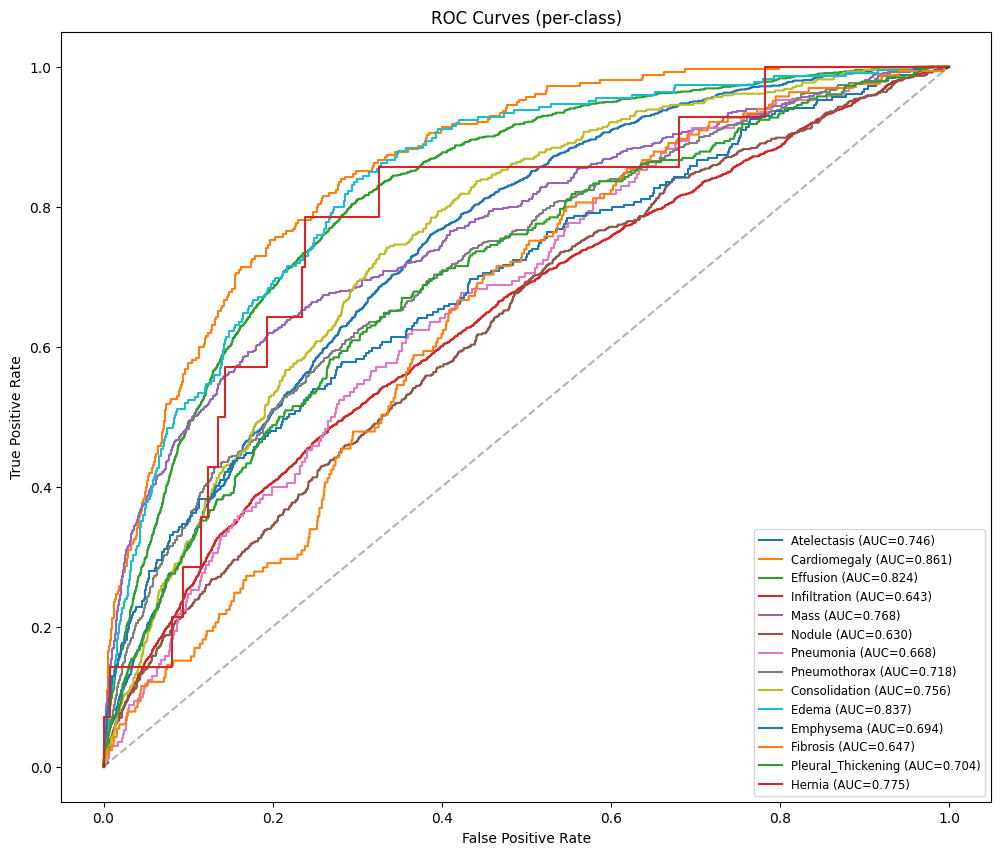

Saved: /content/drive/MyDrive/multidisease detection/evaluation_results/roc_per_class.png


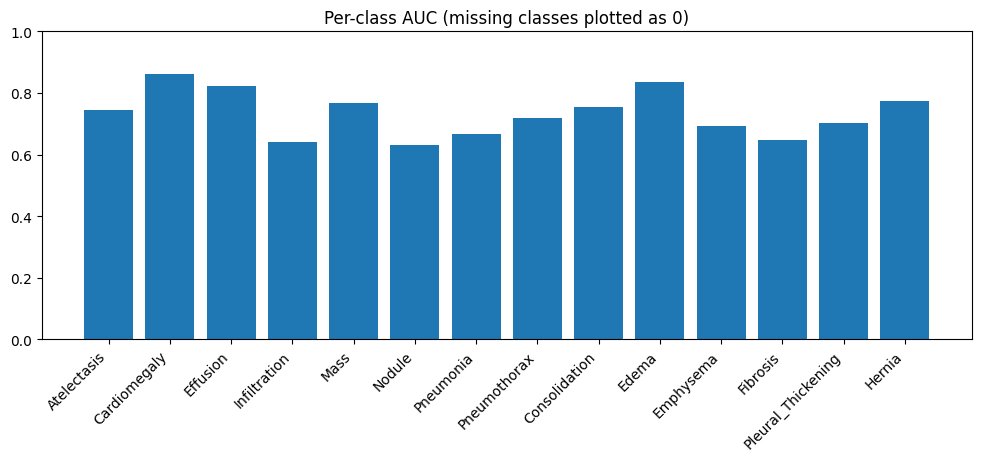

Saved: /content/drive/MyDrive/multidisease detection/evaluation_results/per_class_auc.png


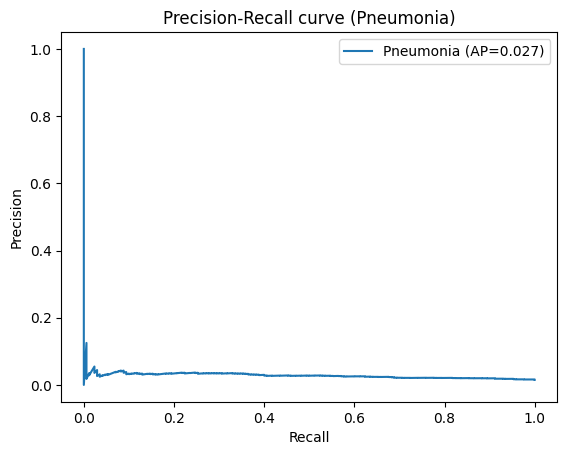

Saved: /content/drive/MyDrive/multidisease detection/evaluation_results/pr_pneumonia.png


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve


plt.figure(figsize=(12,10))
valid_idx = []
for i, cname in enumerate(CLASS_NAMES):
    if np.unique(y_true[:,i]).size < 2:
        continue
    fpr, tpr, _ = roc_curve(y_true[:,i], y_pred[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (per-class)')
plt.legend(loc='lower right', fontsize='small')
roc_png = os.path.join(OUTPUT_DIR, 'roc_per_class.png')
plt.savefig(roc_png, bbox_inches='tight', dpi=150)
plt.show()
print("Saved:", roc_png)

aucs = [metrics['per_class_auc'][c] if metrics['per_class_auc'][c] is not None else 0.0 for c in CLASS_NAMES]
plt.figure(figsize=(12,4))
plt.bar(CLASS_NAMES, aucs)
plt.xticks(rotation=45, ha='right')
plt.title('Per-class AUC (missing classes plotted as 0)')
plt.ylim(0,1)
auc_png = os.path.join(OUTPUT_DIR, 'per_class_auc.png')
plt.savefig(auc_png, bbox_inches='tight', dpi=150)
plt.show()
print("Saved:", auc_png)

if 'Pneumonia' in CLASS_NAMES:
    i = CLASS_NAMES.index('Pneumonia')
    if np.unique(y_true[:,i]).size >= 2:
        p, r, _ = precision_recall_curve(y_true[:,i], y_pred[:,i])
        ap = auc(r, p)
        plt.figure()
        plt.plot(r, p, label=f"Pneumonia (AP={ap:.3f})")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve (Pneumonia)')
        plt.legend()
        pr_png = os.path.join(OUTPUT_DIR, 'pr_pneumonia.png')
        plt.savefig(pr_png, bbox_inches='tight', dpi=150)
        plt.show()
        print("Saved:", pr_png)


In [ ]:
from sklearn.metrics import classification_report
print("Classification report (threshold=0.5):")
print(classification_report(y_true, y_pred_bin, target_names=CLASS_NAMES, zero_division=0))

report = classification_report(y_true, y_pred_bin, target_names=CLASS_NAMES, zero_division=0, output_dict=True)
import json
with open(os.path.join(OUTPUT_DIR, 'classification_report.json'), 'w') as f:
    json.dump(report, f, indent=2)
print("Classification report saved.")


Classification report (threshold=0.5):
                    precision    recall  f1-score   support

       Atelectasis       0.43      0.01      0.02      1108
      Cardiomegaly       0.44      0.02      0.03       255
          Effusion       0.42      0.41      0.41      1325
      Infiltration       0.50      0.00      0.00      1976
              Mass       0.59      0.03      0.05       559
            Nodule       0.00      0.00      0.00       612
         Pneumonia       0.00      0.00      0.00       170
      Pneumothorax       0.23      0.07      0.11       507
     Consolidation       0.00      0.00      0.00       441
             Edema       0.00      0.00      0.00       225
         Emphysema       0.23      0.12      0.16       254
          Fibrosis       0.00      0.00      0.00       165
Pleural_Thickening       0.00      0.00      0.00       330
            Hernia       0.00      0.00      0.00        14

         micro avg       0.39      0.08      0.13      7941

In [ ]:
import shutil
shutil.make_archive(os.path.join(PROJECT_DIR, 'evaluation_results'), 'zip', OUTPUT_DIR)
print("Zipped results to:", os.path.join(PROJECT_DIR, 'evaluation_results.zip'))


Zipped results to: /content/drive/MyDrive/multidisease detection/evaluation_results.zip
